## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

/home/xiaoli/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = 'data/planet/'

In [5]:
# Data preparation steps if you are using Crestle:

os.makedirs('./data/planet/models', exist_ok=True)
os.makedirs('./cache/planet/tmp', exist_ok=True)

# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/test-jpg {PATH}
# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
# !ln -s /cache/planet/tmp {PATH}

In [6]:
ls {PATH}

models/    test-jpg.tar.7z  train-jpg.tar.7z  train_v2.csv.zip
test-jpg/  train-jpg/       train_v2.csv


## Multi-label versus single-label classification

In [7]:
from fastai.plots import *

In [8]:
def get_1st(path): return glob(f'{path}/*.*')[0]

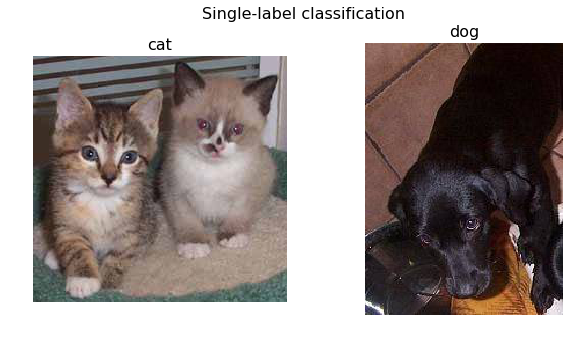

In [9]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

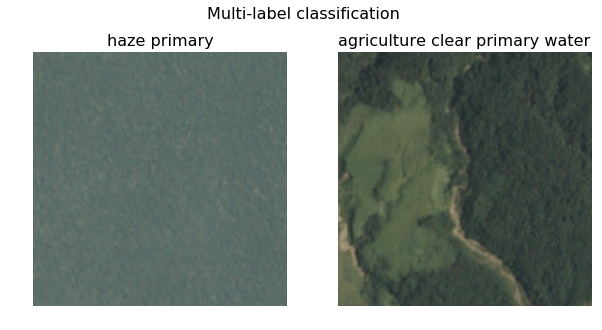

In [10]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more classes. In the previous example, the first image belongs to two classes: *haze* and *primary*. The second image belongs to four classes: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [11]:
from planet import f2

metrics=[f2]
f_model = resnet34 ####

In [31]:
f2?

In [12]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [37]:
ImageClassifierData.from_csv?

In [13]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [14]:
data = get_data(256)

In [15]:
x,y = next(iter(data.val_dl))

In [32]:
y.shape

torch.Size([64, 17])

In [17]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

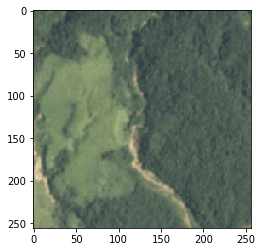

In [18]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

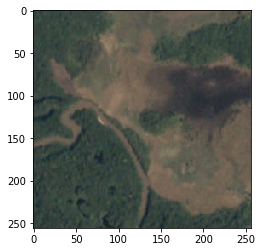

In [ ]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [19]:
sz=64

In [20]:
data = get_data(sz)

In [21]:
data = data.resize(int(sz*1.3), 'tmp')

In [22]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

epoch      trn_loss   val_loss   f2                          
    0      0.227326   0.356349   0.816512  



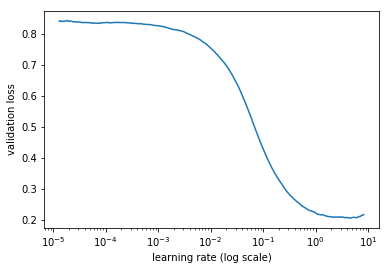

In [23]:
lrf=learn.lr_find()
learn.sched.plot()

A Jupyter Widget

[ 0.       0.22404  0.31176  0.82044]                        



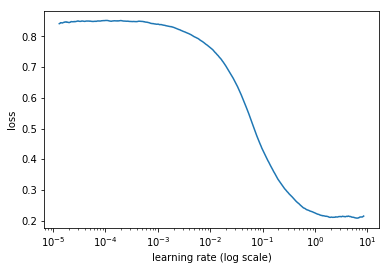

In [ ]:
lrf=learn.lr_find()
learn.sched.plot()

In [24]:
lr = 0.2

In [25]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.146196   0.133601   0.883022  
    1      0.141863   0.127768   0.888754                    
    2      0.139955   0.125765   0.891195                    
    3      0.137488   0.125508   0.889513                    
    4      0.134645   0.123139   0.893253                    
    5      0.133357   0.121557   0.89544                     
    6      0.132655   0.121487   0.894932                    



[array([0.12149]), 0.8949318461241802]

In [26]:
lrs = np.array([lr/9,lr/3,lr])

In [27]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.120759   0.108598   0.908502  
    1      0.113285   0.103582   0.912607                    
    2      0.108791   0.100757   0.916331                    
    3      0.109248   0.10305    0.913337                    
    4      0.107574   0.099322   0.916424                    
    5      0.099738   0.096742   0.91792                      
    6      0.098812   0.096822   0.918155                     



[array([0.09682]), 0.918155087115957]

In [28]:
learn.save(f'{sz}')

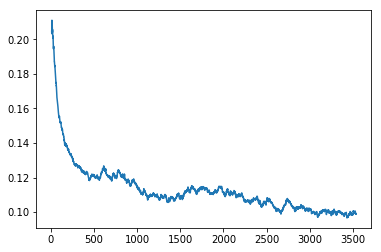

In [29]:
learn.sched.plot_loss()

In [30]:
sz=128

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09729  0.09375  0.91885]                         
[ 1.       0.10118  0.09243  0.92075]                         
[ 2.       0.09805  0.09143  0.92235]                         
[ 3.       0.09834  0.09134  0.92263]                         
[ 4.       0.096    0.09046  0.9231 ]                         
[ 5.       0.09584  0.09035  0.92403]                         
[ 6.       0.09262  0.09059  0.92358]                         



In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.09623  0.08693  0.92696]                         
[ 1.       0.09371  0.08621  0.92887]                         
[ 2.       0.08919  0.08296  0.93113]                         
[ 3.       0.09221  0.08579  0.92709]                         
[ 4.       0.08994  0.08575  0.92862]                         
[ 5.       0.08729  0.08248  0.93108]                         
[ 6.       0.08218  0.08315  0.92971]                         



In [ ]:
sz=256

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09161  0.08651  0.92712]                         
[ 1.       0.08933  0.08665  0.92677]                         
[ 2.       0.09125  0.08584  0.92719]                         
[ 3.       0.08732  0.08532  0.92812]                         
[ 4.       0.08736  0.08479  0.92854]                         
[ 5.       0.08807  0.08471  0.92835]                         
[ 6.       0.08942  0.08448  0.9289 ]                         



In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.08932  0.08218  0.9324 ]                         
[ 1.       0.08654  0.08195  0.93313]                         
[ 2.       0.08468  0.08024  0.93391]                         
[ 3.       0.08596  0.08141  0.93287]                         
[ 4.       0.08211  0.08152  0.93401]                         
[ 5.       0.07971  0.08001  0.93377]                         
[ 6.       0.07928  0.0792   0.93554]                         



In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [ ]:
f2(preds,y)

0.93626519738612801

### End